# Intro to Robotics: Exercise 4
# Author: Samuel Law & Rhys Miller

In [1]:
%reset -f

In [2]:
%matplotlib inline

In [3]:
import sympy as sm
import sympy.physics.mechanics as me
from scipy.integrate import RK45
from numpy import array, vstack, pi, sqrt, arccos, sin, cos, linalg, linspace
from math import degrees
import matplotlib.pyplot as plt

### Kinematics

In [4]:
# setup N frame
N = me.ReferenceFrame("N")
pN = me.Point("pN")
pN.set_vel(N, 0)

In [5]:
# set up constants
g, gr, L = sm.symbols("g, gr, L")

In [6]:
# set up independent variables
q1, q2, q4, q5, u1, u2, u4, u5 = me.dynamicsymbols("q1, q2, q4, q5, u1, u2, u4, u5")
q1d, q2d, q4d, q5d, u1d, u2d, u4d, u5d = me.dynamicsymbols("q1, q2, q4, q5, u1, u2, u4, u5", 1)

In [7]:
# set up dependent variables which are the gears
q0, q3 = -q1*gr, -q4*gr
u0, u3 = -u1*gr, -u4*gr
q0d, q3d = -q1d*gr, -q4d*gr
u0d, u3d = -u1d*gr, -u4d*gr

In [8]:
# create dict for use when generating ccode
var2sym = {
    # positions
    q1: sm.Symbol("q1"),
    q2: sm.Symbol("q2"),
    q4: sm.Symbol("q4"),
    q5: sm.Symbol("q5"),
    # position derivatives
    q1d: sm.Symbol("q1d"),
    q2d: sm.Symbol("q2d"),
    q4d: sm.Symbol("q4d"),
    q5d: sm.Symbol("q5d"),
    # velocities
    u1: sm.Symbol("u1"),
    u2: sm.Symbol("u2"),
    u4: sm.Symbol("u4"),
    u5: sm.Symbol("u5"),
    # velocity derivatives
    u1d: sm.Symbol("u1d"),
    u2d: sm.Symbol("u2d"),
    u4d: sm.Symbol("u4d"),
    u5d: sm.Symbol("u5d"),
}

In [9]:
# set up the motor bodies
right_motor = me.Body(
    name = "motorR",
    frame = N.orientnew("R", "axis", (q0, N.z)),
    masscenter = pN.locatenew("motorR_COM", 0)
)
left_motor = me.Body(
    name = "motorL",
    frame = N.orientnew("L", "axis", (q3, N.z)),
    masscenter = pN.locatenew("motorL_COM", -L*N.x)
)

In [10]:
# set up the link bodies
bodyA = me.Body(
    name = "bodyA",
    frame = N.orientnew("A", "axis", (q1, N.z))
)
bodyB = me.Body(
    name = "bodyB",
    frame = bodyA.frame.orientnew("B", "axis", (q2, bodyA.frame.z))
)
bodyC = me.Body(
    name = "bodyC",
    frame = N.orientnew("C", "axis", (q4, N.z))
)
bodyD = me.Body(
    name = "bodyD",
    frame = bodyC.frame.orientnew("D", "axis", (q5, bodyC.frame.z))
)

In [11]:
# define the link lengths
bodyA.L1, bodyA.L2 = sm.symbols("LA_1, LA_2")
bodyB.L1, bodyB.L2 = sm.symbols("LB_1, LB_2")
bodyC.L1, bodyC.L2 = sm.symbols("LC_1, LC_2")
bodyD.L1, bodyD.L2 = sm.symbols("LD_1, LD_2")

# define the COM lengths
bodyA.L = sm.symbols("LA_COM")
bodyB.L = sm.symbols("LB_COM")
bodyC.L = sm.symbols("LC_COM")
bodyD.L = sm.symbols("LD_COM")

In [12]:
# set all the positions
bodyA.masscenter = pN.locatenew("pA", bodyA.L*bodyA.frame.x)
bodyB.masscenter = pN.locatenew("pB", (bodyA.L1*bodyA.frame.x) + (bodyB.L*bodyB.frame.x))
bodyC.masscenter = left_motor.masscenter.locatenew("pC", bodyC.L*bodyC.frame.x)
bodyD.masscenter = left_motor.masscenter.locatenew("pD", (bodyC.L1*bodyC.frame.x) + (bodyD.L*bodyD.frame.x))

In [13]:
# set all the velocities
right_motor.masscenter.set_vel(N, 0)
left_motor.masscenter.set_vel(N, 0)
bodyA.masscenter.set_vel(N, bodyA.masscenter.pos_from(pN).dt(N))
bodyB.masscenter.set_vel(N, bodyB.masscenter.pos_from(pN).dt(N))
bodyC.masscenter.set_vel(N, bodyC.masscenter.pos_from(pN).dt(N))
bodyD.masscenter.set_vel(N, bodyD.masscenter.pos_from(pN).dt(N))

In [14]:
# set all the accelerations
bodyA.masscenter.set_acc(N, bodyA.masscenter.vel(N).dt(N))
bodyB.masscenter.set_acc(N, bodyB.masscenter.vel(N).dt(N))
bodyC.masscenter.set_acc(N, bodyC.masscenter.vel(N).dt(N))

In [15]:
# define the independent coordinates
q_ind = [q1, q4]
q_dep = [q2, q5]
u_ind = [u1, u4]
u_dep = [u2, u5]

# and the kinematic differential equations
kde = [
    [q1d - u1],
    [q2d - u2],
    [q4d - u4],
    [q5d - u5],
]

# and create the vector loop equations
zero = pN.locatenew(
    "zero", 
    bodyA.L1*bodyA.frame.x + bodyB.L1*bodyB.frame.x - \
    bodyC.L1*bodyC.frame.x - bodyD.L1*bodyD.frame.x - L*N.x
)

pos_constraints = [zero.pos_from(pN).dot(N.x), 
                   zero.pos_from(pN).dot(N.y)]
vel_constraints = [zero.pos_from(pN).dt(N).dot(N.x), 
                   zero.pos_from(pN).dt(N).dot(N.y)]

In [16]:
KM = me.KanesMethod(
    frame = N, 
    q_ind = q_ind,
    u_ind = u_ind,
    kd_eqs = kde,
    q_dependent = q_dep,
    configuration_constraints = pos_constraints,
    u_dependent = u_dep,
    velocity_constraints = vel_constraints
)

### Dynamics

In [17]:
# define the loads
tau1, tau2 = sm.symbols("tau1, tau2")
loads = [
    # point/frame, force/moment
    (right_motor.masscenter, right_motor.mass*g*-N.z),
    (left_motor.masscenter, left_motor.mass*g*-N.z),
    (bodyA.masscenter, bodyA.mass*g*-N.z),
    (bodyB.masscenter, bodyB.mass*g*-N.z),
    (bodyC.masscenter, bodyC.mass*g*-N.z),
    (bodyD.masscenter, bodyD.mass*g*-N.z),
    (bodyA.frame, tau1*right_motor.frame.z),
    (bodyC.frame, tau2*left_motor.frame.z),
]
# define the bodies
bodies = [right_motor, bodyA, bodyB, left_motor, bodyC, bodyD]

In [18]:
Fr, Fr_star = KM.kanes_equations(bodies, loads)
Fr.shape, Fr_star.shape

((2, 1), (2, 1))

In [19]:
# create container to capture auto generated c++ code
c_code = {}
c_code["tau1"] = sm.ccode(me.msubs(Fr_star[0], var2sym))
c_code["tau2"] = sm.ccode(me.msubs(Fr_star[1], var2sym))

In [20]:
in2m = lambda x: x*25.4/1000
vals = {
    # constants
    g: 9.81,               # N*m
    L: in2m(4),            # m
    gr: 144,               # a.u.
    # joint c-c
    bodyA.L1: in2m(2.4),   # m
    bodyC.L1: in2m(2.4),   # m
    bodyB.L1: in2m(3.2),   # m
    bodyD.L1: in2m(3.2),   # m
    # com properties
    bodyA.L: 0.027,        # m
    bodyC.L: 0.027,        # m
    bodyB.L: 0.04,         # m
    bodyD.L: 0.04,         # m
    # masses
    bodyA.mass: 0.007,     # kg
    bodyC.mass: 0.007,     # kg 
    bodyB.mass: 0.008,     # kg
    bodyD.mass: 0.008,     # kg
    # moments of inertia 
    "bodyA_izz": 6.39e-6,  # kg m^2
    "bodyC_izz": 6.39e-6,  # kg m^2
    "bodyB_izz": 1.01e-5,  # kg m^2
    "bodyD_izz": 1.01e-5,  # kg m^2
    "motorR_izz": 3.3e-7,  # kg m^2
    "motorL_izz": 3.3e-7,  # kg m^2
}

### Code Capture & Function Generation

In [21]:
# create the position matrix
pE = pN.locatenew("pE", (bodyA.L1*bodyA.frame.x) + (bodyB.L1*bodyB.frame.x))
PNE = (pE.pos_from(pN).to_matrix(N))
PNE = PNE.row_del(-1)
c_code["x_current"] = sm.ccode(me.msubs(PNE[0], var2sym))
c_code["y_current"] = sm.ccode(me.msubs(PNE[1], var2sym))

In [22]:
# create callable for the simulation
PNE = PNE.subs(vals)
PNE_func = sm.lambdify([q1, q2], PNE, modules="sympy")
PNE_func(0, 0)

Matrix([
[0.14224],
[      0]])

In [23]:
# create velocity matrix
VNE = pE.pos_from(pN).dt(N).to_matrix(N)
VNE = VNE.row_del(-1)
c_code["xd_current"] = sm.ccode(me.msubs(VNE[0], var2sym))
c_code["yd_current"] = sm.ccode(me.msubs(VNE[1], var2sym))

In [24]:
VNE = VNE.subs(vals)
VNE_func = sm.lambdify([q1, q2, q1d, q2d], VNE, modules="sympy")
VNE_func(0, 0, 1, 0)

Matrix([
[      0],
[0.14224]])

In [25]:
# create the task space controller
Kp, Kv = sm.symbols("Kp, Kv")
X_current = sm.Matrix(sm.symbols("x_current, y_current"))
Xd_current = sm.Matrix(sm.symbols("xd_current, yd_current"))
X_desired = sm.Matrix(sm.symbols("x_desired, y_desired"))
Xd_desired = sm.Matrix(sm.symbols("xd_desired, yd_desired"))
u = (Kv*(Xd_desired - Xd_current)) + (Kp*(X_desired - X_current))
u

Matrix([
[Kp*(-x_current + x_desired) + Kv*(-xd_current + xd_desired)],
[Kp*(-y_current + y_desired) + Kv*(-yd_current + yd_desired)]])

In [26]:
c_code["xdd_desired"] = sm.ccode(me.msubs(u[0], var2sym))
c_code["ydd_desired"] = sm.ccode(me.msubs(u[1], var2sym))

In [27]:
# get the positions
pE_rhs = right_motor.masscenter.locatenew("pE_rhs", (bodyA.L1*bodyA.frame.x) + (bodyB.L1*bodyB.frame.x))
pE_lhs = left_motor.masscenter.locatenew("pE_lhs", (bodyC.L1*bodyC.frame.x) + (bodyD.L1*bodyD.frame.x))

# create the 2x2 matrix
M_rhs = pE_rhs.pos_from(pN).dt(N).to_matrix(N)
M_lhs = pE_lhs.pos_from(pN).dt(N).to_matrix(N)
M_rhs = M_rhs.subs(vals)
M_lhs = M_lhs.subs(vals)
M_rhs = M_rhs.row_del(-1)
M_lhs = M_lhs.row_del(-1)
M = sm.Matrix.vstack(M_rhs, M_lhs)

# create the jacobains
X_rhs = sm.Matrix([q1d, q2d])
X_lhs = sm.Matrix([q4d, q5d])
X = sm.Matrix([q1d, q2d, q4d, q5d])
J_rhs = M_rhs.jacobian(X_rhs)
J_lhs = M_lhs.jacobian(X_lhs)
J = M.jacobian(X)
J_rhs.shape, J_lhs.shape, J.shape

((2, 2), (2, 2), (4, 4))

In [28]:
# extract the Jacobina c++ code
rows, cols = J.shape
for r in range(rows):
    for c in range(cols):
        c_code[f"J({r},{c})"] = J[r, c]

In [29]:
# create jocobain callable
J_func = sm.lambdify([q1, q2, q4, q5], J, modules="sympy")
J_func(1, 1, 1, 1)

Matrix([
[                -0.16256*sin(1)*cos(1) - 0.06096*sin(1),                 -0.16256*sin(1)*cos(1),                                                       0,                                      0],
[-0.08128*sin(1)**2 + 0.08128*cos(1)**2 + 0.06096*cos(1), -0.08128*sin(1)**2 + 0.08128*cos(1)**2,                                                       0,                                      0],
[                                                      0,                                      0,                 -0.16256*sin(1)*cos(1) - 0.06096*sin(1),                 -0.16256*sin(1)*cos(1)],
[                                                      0,                                      0, -0.08128*sin(1)**2 + 0.08128*cos(1)**2 + 0.06096*cos(1), -0.08128*sin(1)**2 + 0.08128*cos(1)**2]])

In [30]:
# create the jacobian derivative
Jd = sm.diff(J, 't')

# collect the c-code
rows, cols = Jd.shape
for r in range(rows):
    for c in range(cols):
        c_code[f"J({r},{c})"] = Jd[r, c]

In [31]:
# create the jacobian derivative callable
Jd_func = sm.lambdify([q1, q2, q4, q5, q1d, q2d, q4d, q5d], Jd, modules="sympy")
Jd_func(1, 1, 1, 1, 1, 1, 1, 1)

Matrix([
[-0.16256*cos(1)**2 - 0.06096*cos(1) + 0.16256*sin(1)**2, -0.16256*cos(1)**2 + 0.16256*sin(1)**2,                                                       0,                                      0],
[                -0.32512*sin(1)*cos(1) - 0.06096*sin(1),                 -0.32512*sin(1)*cos(1),                                                       0,                                      0],
[                                                      0,                                      0, -0.16256*cos(1)**2 - 0.06096*cos(1) + 0.16256*sin(1)**2, -0.16256*cos(1)**2 + 0.16256*sin(1)**2],
[                                                      0,                                      0,                 -0.32512*sin(1)*cos(1) - 0.06096*sin(1),                 -0.32512*sin(1)*cos(1)]])

### Inverse Kinematics

In [32]:
# create length vectors
p1 = right_motor.masscenter.locatenew("p1", bodyA.L1*bodyA.frame.x)
p2 = left_motor.masscenter.locatenew("p2", bodyC.L1*bodyC.frame.x)

# calculate gamma using the law of cosines
W = p2.pos_from(p1)
gamma = sm.acos(W.magnitude()/(2*bodyB.L1))
c_code["gamma"] = sm.ccode(me.msubs(gamma, var2sym))
gamma

acos(sqrt(L**2 + 2*L*LA_1*cos(q1(t)) - 2*L*LC_1*cos(q4(t)) + LA_1**2 - 2*LA_1*LC_1*(sin(q1(t))*sin(q4(t)) + cos(q1(t))*cos(q4(t))) + LC_1**2)/(2*LB_1))

In [33]:
# substitute in numerical values
gamma = gamma.subs(vals)

# create gamma function
gamma_func = sm.lambdify([q1, q4], gamma, modules="numpy")
gamma_func(pi/2, pi/2)

0.8956647938578651

In [34]:
# create expression for alpha1
alpha1 = sm.acos(W.dot(-p1.pos_from(right_motor.masscenter))/(W.magnitude()*p1.pos_from(right_motor.masscenter).magnitude()) )
c_code["alpha1"] = sm.ccode(me.msubs(alpha1, var2sym))
alpha1

acos((L*LA_1*cos(q1(t)) + LA_1**2 - LA_1*LC_1*(sin(q1(t))*sin(q4(t)) + cos(q1(t))*cos(q4(t))))/(sqrt(L**2 + 2*L*LA_1*cos(q1(t)) - 2*L*LC_1*cos(q4(t)) + LA_1**2 - 2*LA_1*LC_1*(sin(q1(t))*sin(q4(t)) + cos(q1(t))*cos(q4(t))) + LC_1**2)*sqrt(LA_1**2)))

In [35]:
# sub in numbers
alpha1 = alpha1.subs(vals)
alpha1

acos(123.111071230235*(-0.0037161216*sin(q1(t))*sin(q4(t)) - 0.0037161216*cos(q1(t))*cos(q4(t)) + 0.006193536*cos(q1(t)) + 0.0037161216)/sqrt(-0.418604651162791*sin(q1(t))*sin(q4(t)) - 0.418604651162791*cos(q1(t))*cos(q4(t)) + 0.697674418604651*cos(q1(t)) - 0.697674418604651*cos(q4(t)) + 1))

In [36]:
# create expression for alpha2
alpha2 = q1 - q4 - alpha1 + sm.pi
c_code["alpha2"] = sm.ccode(me.msubs(alpha2, var2sym))
alpha2

q1(t) - q4(t) - acos(123.111071230235*(-0.0037161216*sin(q1(t))*sin(q4(t)) - 0.0037161216*cos(q1(t))*cos(q4(t)) + 0.006193536*cos(q1(t)) + 0.0037161216)/sqrt(-0.418604651162791*sin(q1(t))*sin(q4(t)) - 0.418604651162791*cos(q1(t))*cos(q4(t)) + 0.697674418604651*cos(q1(t)) - 0.697674418604651*cos(q4(t)) + 1)) + pi

In [37]:
# create callables for alpha1 and alpha2
alpha_func = sm.lambdify([q1, q4], [alpha1, alpha2], modules="numpy")
alpha_func(pi/2, pi/2)

[1.5707963267948966, 1.5707963267948966]

In [38]:
# solve for q2d and q5d using vector loop constraint
M = zero.pos_from(pN).dt(N).to_matrix(N)
M = M.subs(vals)
sol = sm.solve([M], [q2d, q5d])
sol

{Derivative(q2(t), t): 0.25*(3.0*sin(-q1(t) + q4(t) + q5(t))*Derivative(q1(t), t) - 4.0*sin(q1(t) + q2(t) - q4(t) - q5(t))*Derivative(q1(t), t) - 3.0*sin(q5(t))*Derivative(q4(t), t))/sin(q1(t) + q2(t) - q4(t) - q5(t)),
 Derivative(q5(t), t): 0.25*(-3.0*sin(q1(t) + q2(t) - q4(t))*Derivative(q4(t), t) - 4.0*sin(q1(t) + q2(t) - q4(t) - q5(t))*Derivative(q4(t), t) + 3.0*sin(q2(t))*Derivative(q1(t), t))/sin(q1(t) + q2(t) - q4(t) - q5(t))}

In [39]:
eq1 = me.msubs(sol[q2d], var2sym)
eq2 = me.msubs(sol[q5d], var2sym)
c_code["q2d"] = eq1
c_code["q5d"] = eq2

In [40]:
qd_func = sm.lambdify([q1, q2, q4, q5, q1d, q4d], [sol[q2d], sol[q5d]], modules="numpy")
qd_func(pi/2, 0.68, pi/2, -0.68, 1, 1)

[-1.0, -1.0000000000000002]

### Simulation

In [41]:
# x1 = q1,    x1d = q1d
# x2 = q4,    x2d = q4d
# x3 = q1d,   x3d = q1dd
# x4 = q4d,   x4d = q4dd

# declare controller variables
KP = 100
KV = sqrt(KP*8)

# declare globals for point tracking
X_CURRENT, Y_CURRENT = 0, 0
X_DESIRED, Y_DESIRED = 0, 0

def model(t, x):
    # unpack the vector
    q1, q4, q1d, q4d = x
    
    # get gamma, alpha1, and alpha2
    gamma = gamma_func(q1, q4)
    alpha1, alpha2 = alpha_func(q1, q4)
    
    # solve for q2, and q5
    q2 = pi - (alpha1 + gamma)
    q5 = pi + (alpha2 + gamma)
     
    # solve for the velocities
    q2d, q5d = qd_func(q1, q2, q4, q5, q1d, q4d)
    
    
    # calculate point E position
    x, y = PNE_func(q1, q2)
    
    # assign to global namespace
    global X_CURRENT, Y_CURRENT
    X_CURRENT, Y_CURRENT = x, y
    
    # calculate the speeds
    xd, yd = VNE_func(q1, q2, q1d, q2d)
    
    # calculate the controller output
    global X_DESIRED, Y_DESIRED, KP, KV
    u = (KV*(sm.Matrix([0 - xd, 0 - yd]))) + \
        (KP*(sm.Matrix([X_DESIRED - x, Y_DESIRED - y])))
    
    # create task space acceleration vector
    Xdd = sm.Matrix.vstack(u, u)
    
    # calculate the jacobian
    J = J_func(q1, q2, q4, q5)
    
    # calculate the angular velocities
    Xd = sm.Matrix([xd, yd, xd, yd])
    q1d, q2d, q4d, q5d = J.inv()*Xd
    
    # calculate the desired accelerations
    Jd = Jd_func(q1, q2, q4, q5, q1d, q2d, q4d, q5d)
    q1dd, q2dd, q4dd, q5dd = J.inv()*(Xdd - (Jd*sm.Matrix([q1d, q2d, q4d, q5d])))
                    
    # assign the xdots
    x1d = q1d
    x2d = q4d
    x3d = q1dd
    x4d = q4dd
    
    # return the values
    return (x1d, x2d, x3d, x4d)

In [42]:
# create the callable for the target point
R, r, d = in2m(0.5), in2m(0.1), in2m(0.65)
x_offset, y_offset = -in2m(2), in2m(4)
xh = lambda theta: float(((R-r)*cos(theta)) + (d*cos((R-r)*(theta/r))) + x_offset)
yh = lambda theta: float(((R-r)*sin(theta)) - (d*sin((R-r)*(theta/r))) + y_offset)

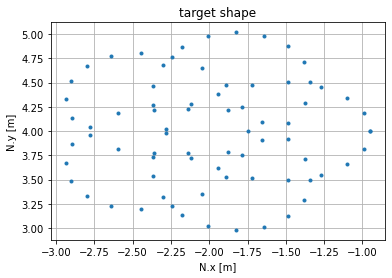

In [43]:
m2in = lambda x: x*1000/25.4
thetas = linspace(0, 2*pi, 75)
x_vals = [xh(t) for t in thetas]
y_vals = [yh(t) for t in thetas]
plt.plot([m2in(v) for v in x_vals], [m2in(v) for v in y_vals], '.')
plt.grid()
plt.title("target shape")
plt.xlabel("N.x [m]")
plt.ylabel("N.y [m]");

In [46]:
# create the containers and error theshold
conditions = array([pi/2, pi/2, 0, 0])
times = array([0])
results = array([0, 0])
eps = 0.001


# create the function that runs the interval
def run_interval(theta, times, conditions, results):
    # set up this leg of the simulation
    simulator = RK45(model, times[0], conditions, 1, max_step = 0.1)
    global X_DESIRED, Y_DESIRED
    X_DESIRED = xh(theta)
    Y_DESIRED = yh(theta)
    
    # run this leg of the simulation
    while True:
        # attempt to step
        try:
            simulator.step()
        # if the solver is finished
        except Exception as e:
            break
        # if the step was successful
        else:
            # if it's close enough to the target
            if linalg.norm([float(X_DESIRED - X_CURRENT), float(Y_DESIRED - Y_CURRENT)]) <= eps:
                break
            # if its not close enough to the target
            else:
                times = vstack([times, simulator.t])
                conditions = simulator.y
                results = vstack([results, (X_CURRENT, Y_CURRENT)])
            
    # return this leg of the simulation
    return theta, times, conditions, results


# run all the intervals
theta = 0
while theta < 7:
    # put in the last conditions
    theta, times, conditions, results = run_interval(theta, times, conditions, results)
    theta += 0.1

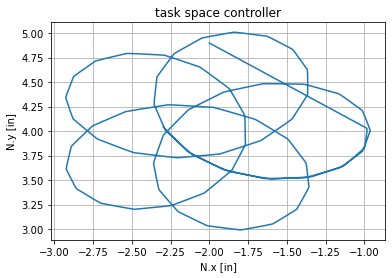

In [47]:
x = [m2in(x) for x in results[1::, 0]]
y = [m2in(y) for y in results[1::, 1]]
plt.plot(x, y)
plt.grid()
plt.title("task space controller")
plt.xlabel("N.x [in]")
plt.ylabel("N.y [in]");

### Auto generate C++ 

In [48]:
# print out c_code expressions
for key, value in c_code.items():
    print(f"{key} = {value}\n")

tau1 = -LA_1*LB_COM*bodyB_mass*pow(u1, 2)*sin(q2) + LA_1*LB_COM*bodyB_mass*pow(u1 + u2, 2)*sin(q2) - u1d*(pow(LA_COM, 2)*bodyA_mass + bodyA_izz + bodyB_izz + bodyB_mass*(pow(LA_1, 2) + 2*LA_1*LB_COM*cos(q2) + pow(LB_COM, 2)) + pow(gr, 2)*motorR_izz) - u2d*(bodyB_izz + bodyB_mass*(LA_1*LB_COM*cos(q2) + pow(LB_COM, 2))) - (LA_1*cos(q1) + LB_1*(-sin(q1)*sin(q2) + cos(q1)*cos(q2)) - (-LA_1*sin(q1) + LB_1*(-sin(q1)*cos(q2) - sin(q2)*cos(q1)))*(-sin(q1)*sin(q2) + cos(q1)*cos(q2))/(-sin(q1)*cos(q2) - sin(q2)*cos(q1)))*(-LC_1*LD_COM*bodyD_mass*pow(u4, 2)*sin(q5) - u4d*(bodyD_izz + bodyD_mass*(LC_1*LD_COM*cos(q5) + pow(LD_COM, 2))) - u5d*(pow(LD_COM, 2)*bodyD_mass + bodyD_izz))/(LD_1*(-sin(q1)*sin(q2) + cos(q1)*cos(q2))*(-sin(q4)*cos(q5) - sin(q5)*cos(q4))/(-sin(q1)*cos(q2) - sin(q2)*cos(q1)) - LD_1*(-sin(q4)*sin(q5) + cos(q4)*cos(q5))) - (-LA_1*sin(q1) + LB_1*(-sin(q1)*cos(q2) - sin(q2)*cos(q1)) + LD_1*(-sin(q4)*cos(q5) - sin(q5)*cos(q4))*(LA_1*cos(q1) + LB_1*(-sin(q1)*sin(q2) + cos(q1)*cos(q2

### Generate points for arduino vectors

In [49]:
print("x_vals")
for i, v in enumerate(x_vals[5::5], 5):
    print(*x_vals[i-5:i],"", sep=",")
print("y_vals")
for i, v in enumerate(y_vals[5::5], 5):
    print(*y_vals[i-5:i],"", sep=",")

x_vals
-0.024130000000000002,-0.025109694891845433,-0.027940772047069844,-0.03231152000762576,-0.037742050406485934,
-0.025109694891845433,-0.027940772047069844,-0.03231152000762576,-0.037742050406485934,-0.043638982741677504,
-0.027940772047069844,-0.03231152000762576,-0.037742050406485934,-0.043638982741677504,-0.04936304043722211,
-0.03231152000762576,-0.037742050406485934,-0.043638982741677504,-0.04936304043722211,-0.05430183707487175,
-0.037742050406485934,-0.043638982741677504,-0.04936304043722211,-0.05430183707487175,-0.05793953911243276,
-0.043638982741677504,-0.04936304043722211,-0.05430183707487175,-0.05793953911243276,-0.05991544862125914,
-0.04936304043722211,-0.05430183707487175,-0.05793953911243276,-0.05991544862125914,-0.06006481576422884,
-0.05430183707487175,-0.05793953911243276,-0.05991544862125914,-0.06006481576422884,-0.05843722123776428,
-0.05793953911243276,-0.05991544862125914,-0.06006481576422884,-0.05843722123776428,-0.055290431739842306,
-0.05991544862125914,-